In [1]:
import os
import numexpr as ne
import sys
import cactusLib.cactusUtils as cu
from cactusLib.cactusLib import mapAnalysisObject2 as mao
from cactusLib.cactusCatalogs import readCatalog
import numpy as np
import os
from datetime import datetime
import scipy
from flipper import fftTools
from cactusLib import filterLib
import matplotlib.pyplot as plt
from cactusLib.cactusBeams import getBeamSpline, getBeamNorm
from scipy import ndimage
from cactusLib.filterLib import symmetrizeFFT

import matplotlib.pyplot as plt

/home/cvargas/.local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .circular_overlap import *       # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .elliptical_overlap import *     # noqa
/home/cvargas/miniconda2/lib/python2.7/site-packages/photutils/geometry/__init__.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .rectangular_overlap import *    # noqa


In [2]:
paramfile = "./ar2s2.par"
#simrange = [0,1]
outdir = "test_sim_maps_nr"
catname = "./test_sim_cats/"
tag = "ACT_220_s2_sim_full"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
startTime = datetime.now()
ma = mao(paramfile)
mapData = ma.Map.map.data.copy()
#print "Processing sim %d/%d" % (i+1, simrange[1] - simrange[0])

#print "Proccessing sim{}".format(i)

ma.Map.map.data = mapData.copy()

In [3]:
ltmap = ma.Map.map.copy()

In [4]:
FTmap = fftTools.fftFromLiteMap(ltmap)

In [5]:
lt = ma.Map.map.copy()
lt.data[:] = lt.data*np.sqrt(ma.Map.weights.data)/np.sqrt(np.max(ma.Map.weights.data))

noiseMap = lt.copy()

pad = 40
extraYPad = 0
apodNy,apodNx = noiseMap.data.shape
apod = np.zeros((apodNy,apodNx))
apod[pad+extraYPad:apodNy-pad-extraYPad,pad:apodNx-pad] = 1.0
N_apod = scipy.ndimage.gaussian_filter(apod,80,mode="constant")

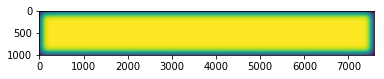

In [6]:
plt.imshow(N_apod)

In [7]:
pix_size = np.sqrt(ltmap.pixScaleX*ltmap.pixScaleY)*60.*180./np.pi
Ny = ltmap.Ny
Nx = ltmap.Nx

#Adding noise

white_noise_level = 30. #microkelvin square per degree
atmospheric_noise_level = 0.5*0.  # multiply by zero to turn this off
one_over_f_noise_level = 2.0 * 1. # multiply by zero to turn this off

## make a white noise map
white_noise = np.random.normal(0,1,(Ny,Nx)) * white_noise_level/pix_size



In [8]:
np.sum(np.random.normal(0,1,(Ny,Nx))**2)/(Nx*Ny)

1.000657917575332

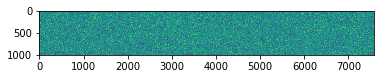

In [9]:
plt.imshow(white_noise)

In [10]:
A = np.sqrt(Nx*Ny*np.sum(np.abs(white_noise)**2)/  np.sum(np.abs(np.fft.fft2(white_noise*N_apod))**2))

In [11]:
A

1.1157000483303383

In [12]:
A = np.sqrt(Nx*Ny)/(np.sqrt(np.sum(np.abs(N_apod)**2)))
print A

1.115652775601516


In [13]:
#A = Nx*Ny*np.sum(N_apod**2)/(np.sum(N_apod))**2
#print A

In [14]:
nl = np.mean(np.abs(np.fft.fft2(white_noise)))*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

In [15]:
nl

0.007730992053557475

In [16]:
bins = np.linspace(1000.,15000.,70)

#No factor

#FT = np.fft.fft2(white_noise)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)
FT = np.fft.fft2(white_noise*N_apod)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)
mL = FTmap.modLMap
Cl0 = []
ell0 = []
for i in range(len(bins)-1):
    c1 = mL>bins[i]
    c2 = mL<bins[i+1]
    c = c1.astype(int)*c2.astype(int)
    c = c.astype(bool)
    #Clbin = np.mean(smooth[c])
    FT_abs = np.abs(FT)
    Clbin = np.mean(FT_abs[c])
    lbin = np.mean(FTmap.modLMap[c])
    #lbin = np.mean([bins[i],bins[i+1]])
    #print lbin
    Cl0.append(Clbin)
    ell0.append(lbin)

    
FT = np.fft.fft2(white_noise*N_apod)*np.sqrt(FTmap.pixScaleX*FTmap.pixScaleY)/np.sqrt(FTmap.kMap.size)

Cl1 = []
ell1 = []

for i in range(len(bins)-1):
    c1 = mL>bins[i]
    c2 = mL<bins[i+1]
    c = c1.astype(int)*c2.astype(int)
    c = c.astype(bool)
    #Clbin = np.mean(smooth[c])
    FT_abs = A*np.abs(FT)
    Clbin = np.mean(FT_abs[c])
    lbin = np.mean(FTmap.modLMap[c])
    #lbin = np.mean([bins[i],bins[i+1]])
    #print lbin
    Cl1.append(Clbin)
    ell1.append(lbin)  

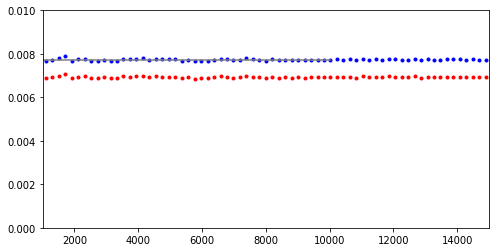

In [17]:
plt.figure(figsize=(8,4))
plt.plot(ell0,Cl0,"r.")

plt.plot(ell1,Cl1,"b.")

#plt.xlim(bins[0],10000.)
#plt.ylim(0.,0.08)

plt.xlim(1000.,15000.)
plt.ylim(0.,0.01)

x0 = np.linspace(bins[0],10000.)
y0 = x0*0.+nl
plt.plot(x0,y0,color="gray")
